In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
import sys
import io
import pprint

from dataclasses import dataclass, field
from typing import List, Dict, Optional, Any, Union
from collections import Counter
from datetime import datetime, date
from pandas.testing import assert_series_equal

# pd.set_option('display.max_rows', None)  display all rows
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.precision", 4)

# ==============================================================================
# SECTION A: CORE HELPER FUNCTIONS & FEATURE GENERATION
# (Unchanged from previous version)
# ==============================================================================
# ... (Keep generate_features, calculate_gain, calculate_sharpe,
#      calculate_sharpe_atr, calculate_buy_and_hold_performance as is) ...


def generate_features(
    df_ohlcv: pd.DataFrame,
    atr_period: int = 14,
    quality_window: int = 252,
    quality_min_periods: int = 126,
) -> pd.DataFrame:
    # 1. Sort and Group
    if not df_ohlcv.index.is_monotonic_increasing:
        df_ohlcv = df_ohlcv.sort_index()
    grouped = df_ohlcv.groupby(level="Ticker")

    # 2. ATR Calculation (Existing)
    prev_close = grouped["Adj Close"].shift(1)
    tr = pd.concat(
        [
            df_ohlcv["Adj High"] - df_ohlcv["Adj Low"],
            abs(df_ohlcv["Adj High"] - prev_close),
            abs(df_ohlcv["Adj Low"] - prev_close),
        ],
        axis=1,
    ).max(axis=1, skipna=False)

    atr = tr.groupby(level="Ticker").transform(
        lambda x: x.ewm(alpha=1 / atr_period, adjust=False).mean()
    )
    atrp = (atr / df_ohlcv["Adj Close"]).replace([np.inf, -np.inf], np.nan)

    # 3. --- NEW: MOMENTUM / RETURN FEATURES ---
    # We calculate percentage change for specific windows useful for Pullbacks (3D, 5D) and Trends (21D)
    # Note: We use grouped.pct_change to respect Ticker boundaries
    roc_1 = grouped["Adj Close"].pct_change(1)
    roc_3 = grouped["Adj Close"].pct_change(3)
    roc_5 = grouped["Adj Close"].pct_change(5)
    roc_10 = grouped["Adj Close"].pct_change(10)
    roc_21 = grouped["Adj Close"].pct_change(21)

    indicator_df = pd.DataFrame(
        {
            "TR": tr,
            "ATR": atr,
            "ATRP": atrp,
            "ROC_1": roc_1,
            "ROC_3": roc_3,
            "ROC_5": roc_5,
            "ROC_10": roc_10,
            "ROC_21": roc_21,
        }
    )

    # 4. Quality/Liquidity Features (Existing)
    quality_temp_df = pd.DataFrame(
        {
            "IsStale": np.where(
                (df_ohlcv["Volume"] == 0)
                | (df_ohlcv["Adj High"] == df_ohlcv["Adj Low"]),
                1,
                0,
            ),
            "DollarVolume": df_ohlcv["Adj Close"] * df_ohlcv["Volume"],
            "HasSameVolume": (grouped["Volume"].diff() == 0).astype(int),
        },
        index=df_ohlcv.index,
    )

    rolling_result = (
        quality_temp_df.groupby(level="Ticker")
        .rolling(window=quality_window, min_periods=quality_min_periods)
        .agg({"IsStale": "mean", "DollarVolume": "median", "HasSameVolume": "sum"})
        .rename(
            columns={
                "IsStale": "RollingStalePct",
                "DollarVolume": "RollMedDollarVol",
                "HasSameVolume": "RollingSameVolCount",
            }
        )
        .reset_index(level=0, drop=True)
    )

    # 5. Merge
    return pd.concat([indicator_df, rolling_result], axis=1)


def calculate_gain(price_series):
    if price_series.dropna().shape[0] < 2:
        return np.nan
    return (price_series.ffill().iloc[-1] / price_series.bfill().iloc[0]) - 1


def calculate_sharpe(return_series):
    if return_series.dropna().shape[0] < 2:
        return np.nan
    std = return_series.std()
    return (return_series.mean() / std * np.sqrt(252)) if std > 0 else 0.0


def calculate_sharpe_atr(return_series, atrp_series):
    if return_series.dropna().shape[0] < 2 or atrp_series.dropna().empty:
        return np.nan
    mean_atrp = atrp_series.mean()
    return (return_series.mean() / mean_atrp) if mean_atrp > 0 else 0.0


def calculate_buy_and_hold_performance(
    df_close, features_df, tickers, start_date, end_date
):
    if not tickers:
        return pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)
    ticker_counts = Counter(tickers)
    initial_weights = pd.Series({t: c / len(tickers) for t, c in ticker_counts.items()})
    prices_raw = df_close[initial_weights.index.tolist()].loc[start_date:end_date]
    if prices_raw.dropna(how="all").empty:
        return pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)
    prices_norm = prices_raw.div(prices_raw.bfill().iloc[0])
    weighted_growth = prices_norm.mul(initial_weights, axis="columns")
    value_series = weighted_growth.sum(axis=1)
    return_series = value_series.ffill().pct_change()
    full_idx = pd.MultiIndex.from_product(
        [initial_weights.index.tolist(), return_series.index], names=["Ticker", "Date"]
    )
    feat_subset = features_df.reindex(full_idx)["ATRP"].unstack(level="Ticker")
    atrp_series = (
        weighted_growth.div(value_series, axis="index").align(
            feat_subset, join="inner", axis=1
        )[0]
        * weighted_growth.div(value_series, axis="index").align(
            feat_subset, join="inner", axis=1
        )[1]
    ).sum(axis=1)
    return value_series, return_series, atrp_series


# ==============================================================================
# SECTION B: METRIC REGISTRY (UPDATED VARIABLES)
# ==============================================================================


# Note: We now expect 'lookback_close' instead of 'calc_close' in the dictionary
def metric_price(d):
    return calculate_gain(d["lookback_close"])


def metric_sharpe(d):
    r = d["lookback_returns"]  # Was daily_returns
    return (
        (r.mean() / r.std() * np.sqrt(252)).replace([np.inf, -np.inf], np.nan).fillna(0)
    )


def metric_sharpe_atr(d):
    return (
        (d["lookback_returns"].mean() / d["atrp"])
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )


METRIC_REGISTRY = {
    "Price": metric_price,
    "Sharpe": metric_sharpe,
    "Sharpe (ATR)": metric_sharpe_atr,
    # Momentum / Pullback (These use features, so they remain the same)
    "Momentum 1D": lambda d: d["roc_1"],
    "Momentum 3D": lambda d: d["roc_3"],
    "Momentum 5D": lambda d: d["roc_5"],
    "Momentum 10D": lambda d: d["roc_10"],
    "Momentum 1M": lambda d: d["roc_21"],
    "Pullback 1D": lambda d: -d["roc_1"],
    "Pullback 3D": lambda d: -d["roc_3"],
    "Pullback 5D": lambda d: -d["roc_5"],
    "Pullback 10D": lambda d: -d["roc_10"],
    "Pullback 1M": lambda d: -d["roc_21"],
}

# ==============================================================================
# SECTION C: DATA CONTRACTS (UPDATED v2.2 - Verification Ready)
# ==============================================================================


@dataclass
class EngineInput:
    mode: str
    start_date: pd.Timestamp
    lookback_period: int
    holding_period: int
    metric: str
    benchmark_ticker: str
    rank_start: int = 1
    rank_end: int = 10
    quality_thresholds: Dict[str, float] = field(
        default_factory=lambda: {
            "min_median_dollar_volume": 1_000_000,
            "max_stale_pct": 0.05,
            "max_same_vol_count": 10,
        }
    )
    manual_tickers: List[str] = field(default_factory=list)
    debug: bool = False


@dataclass
class EngineOutput:
    portfolio_series: pd.Series
    benchmark_series: pd.Series
    normalized_plot_data: pd.DataFrame
    tickers: List[str]
    initial_weights: pd.Series
    perf_metrics: Dict[str, float]
    results_df: pd.DataFrame

    # Dates
    start_date: pd.Timestamp
    decision_date: pd.Timestamp
    buy_date: pd.Timestamp
    holding_end_date: pd.Timestamp

    error_msg: Optional[str] = None
    debug_data: Optional[Dict[str, Any]] = None


class AlphaEngine:
    def __init__(
        self,
        df_ohlcv: pd.DataFrame,
        features_df: pd.DataFrame = None,
        df_close_wide: pd.DataFrame = None,
        master_ticker: str = "SPY",
    ):
        print("--- ⚙️ Initializing AlphaEngine v2.2 (Transparent Verification) ---")

        # 1. Setup Features
        if features_df is not None:
            self.features_df = features_df
        else:
            print("🐢 Calculating Features from scratch...")
            self.features_df = generate_features(df_ohlcv)

        # 2. Setup Prices
        if df_close_wide is not None:
            self.df_close = df_close_wide
        else:
            print("🐢 Pivoting Price Data (Slow)...")
            self.df_close = df_ohlcv["Adj Close"].unstack(level=0)

        # 3. Setup Calendar
        if master_ticker not in self.df_close.columns:
            master_ticker = self.df_close.columns[0]
        self.trading_calendar = (
            self.df_close[master_ticker].dropna().index.unique().sort_values()
        )

    def run(self, inputs: EngineInput) -> EngineOutput:

        # --- Step 1: Validate Timeline ---
        dates, error = self._validate_timeline(inputs)
        if error:
            return self._error_result(error)
        (safe_start, safe_decision, safe_buy, safe_end) = dates

        # --- Step 2: Select Assets ---
        tickers_to_trade, results_table, debug_dict, error = self._select_tickers(
            inputs, safe_start, safe_decision
        )
        if error:
            return self._error_result(error)

        # --- Step 3: Generate Equity Curves ---
        p_val, p_ret, p_atrp = calculate_buy_and_hold_performance(
            self.df_close, self.features_df, tickers_to_trade, safe_start, safe_end
        )
        b_val, b_ret, b_atrp = calculate_buy_and_hold_performance(
            self.df_close,
            self.features_df,
            [inputs.benchmark_ticker],
            safe_start,
            safe_end,
        )

        # --- Step 4: Calculate Unified Metrics & CAPTURE SLICES ---
        metrics = {}

        # Portfolio Calculation
        p_metrics, p_slices = self._calculate_period_metrics(
            p_val, p_ret, p_atrp, safe_decision, safe_buy, prefix="p"
        )
        metrics.update(p_metrics)

        # Benchmark Calculation
        b_metrics, b_slices = self._calculate_period_metrics(
            b_val, b_ret, b_atrp, safe_decision, safe_buy, prefix="b"
        )
        metrics.update(b_metrics)

        # Store Verification Data
        debug_dict["verification"] = {"portfolio": p_slices, "benchmark": b_slices}

        # --- Step 5: Final Packaging ---
        plot_data = self._get_normalized_plot_data(
            tickers_to_trade, safe_start, safe_end
        )

        if not plot_data.empty and not results_table.empty:
            holding_period_slice = plot_data.loc[safe_buy:]
            if len(holding_period_slice) > 0:
                gains = (
                    holding_period_slice.iloc[-1] / holding_period_slice.iloc[0]
                ) - 1
                results_table["Holding Gain"] = results_table.index.map(gains)

        ticker_counts = Counter(tickers_to_trade)
        weights = pd.Series(
            {t: c / len(tickers_to_trade) for t, c in ticker_counts.items()}
        )

        return EngineOutput(
            portfolio_series=p_val,
            benchmark_series=b_val,
            normalized_plot_data=plot_data,
            tickers=tickers_to_trade,
            initial_weights=weights,
            perf_metrics=metrics,
            results_df=results_table,
            start_date=safe_start,
            decision_date=safe_decision,
            buy_date=safe_buy,
            holding_end_date=safe_end,
            error_msg=None,
            debug_data=debug_dict,
        )

    # ==============================================================================
    # INTERNAL LOGIC MODULES
    # ==============================================================================

    def _validate_timeline(self, inputs: EngineInput):
        cal = self.trading_calendar
        if len(cal) <= inputs.lookback_period:
            return None, f"Dataset too small. Need > {inputs.lookback_period} days."
        min_decision_date = cal[inputs.lookback_period]

        if inputs.start_date < cal[0]:
            return None, f"❌ Date Out of Range. Earliest date is {cal[0].date()}."
        if inputs.start_date < min_decision_date:
            return (
                None,
                f"❌ Not enough history. Try {min_decision_date.date()} or later.",
            )
        if inputs.start_date > cal[-1]:
            return None, f"❌ Date Out of Range. Dataset ends on {cal[-1].date()}."

        decision_idx = cal.searchsorted(inputs.start_date)
        if decision_idx >= len(cal):
            decision_idx = len(cal) - 1

        entry_idx = decision_idx + 1
        if entry_idx >= len(cal):
            return (
                None,
                f"❌ Cannot execute T+1. Decision date {cal[decision_idx].date()} is the last available day.",
            )

        required_end_idx = entry_idx + inputs.holding_period
        if required_end_idx >= len(cal):
            valid_idx = len(cal) - 1 - inputs.holding_period - 1
            valid_date = cal[valid_idx] if valid_idx >= 0 else "N/A"
            return None, (
                f"❌ Not enough future data. Latest valid Decision Date: {valid_date.date()}"
            )

        start_idx = decision_idx - inputs.lookback_period
        return (
            cal[start_idx],
            cal[decision_idx],
            cal[entry_idx],
            cal[required_end_idx],
        ), None

    def _select_tickers(self, inputs: EngineInput, start_date, decision_date):
        debug_dict = {}
        if inputs.mode == "Manual List":
            validation_errors = []
            valid_tickers = []
            for t in inputs.manual_tickers:
                if t not in self.df_close.columns:
                    validation_errors.append(f"❌ {t}: Not found.")
                    continue
                if pd.isna(self.df_close.at[start_date, t]):
                    validation_errors.append(f"⚠️ {t}: No data on start date.")
                    continue
                valid_tickers.append(t)

            if validation_errors:
                return [], pd.DataFrame(), {}, "\n".join(validation_errors)
            if not valid_tickers:
                return [], pd.DataFrame(), {}, "No valid tickers found."
            return valid_tickers, pd.DataFrame(index=valid_tickers), {}, None

        else:  # Ranking
            audit_info = {}
            eligible_tickers = self._filter_universe(
                decision_date, inputs.quality_thresholds, audit_info
            )
            debug_dict["audit_liquidity"] = audit_info

            if not eligible_tickers:
                return (
                    [],
                    pd.DataFrame(),
                    debug_dict,
                    "No tickers passed quality filters.",
                )

            lookback_close = self.df_close.loc[
                start_date:decision_date, eligible_tickers
            ]
            idx_product = pd.MultiIndex.from_product(
                [eligible_tickers, lookback_close.index], names=["Ticker", "Date"]
            )

            feat_slice_current = self.features_df.xs(
                decision_date, level="Date"
            ).reindex(eligible_tickers)
            feat_slice_period = self.features_df.loc[
                (slice(None), lookback_close.index), :
            ].reindex(idx_product)
            atrp_mean = feat_slice_period["ATRP"].groupby(level="Ticker").mean()

            ingredients = {
                "lookback_close": lookback_close,
                "lookback_returns": lookback_close.ffill().pct_change(),
                "atrp": atrp_mean,
                "roc_1": feat_slice_current["ROC_1"],
                "roc_3": feat_slice_current["ROC_3"],
                "roc_5": feat_slice_current["ROC_5"],
                "roc_10": feat_slice_current["ROC_10"],
                "roc_21": feat_slice_current["ROC_21"],
            }

            if inputs.metric not in METRIC_REGISTRY:
                return [], pd.DataFrame(), {}, f"Strategy '{inputs.metric}' not found."
            metric_vals = METRIC_REGISTRY[inputs.metric](ingredients)
            sorted_tickers = metric_vals.sort_values(ascending=False)

            start_r = max(0, inputs.rank_start - 1)
            end_r = inputs.rank_end
            selected_tickers = sorted_tickers.iloc[start_r:end_r].index.tolist()

            if not selected_tickers:
                return (
                    [],
                    pd.DataFrame(),
                    debug_dict,
                    "No tickers generated from ranking.",
                )

            results_table = pd.DataFrame(
                {
                    "Rank": range(
                        inputs.rank_start, inputs.rank_start + len(selected_tickers)
                    ),
                    "Ticker": selected_tickers,
                    "Strategy Value": sorted_tickers.loc[selected_tickers].values,
                }
            ).set_index("Ticker")

            return selected_tickers, results_table, debug_dict, None

    def _filter_universe(self, date_ts, thresholds, audit_container=None):
        avail_dates = (
            self.features_df.index.get_level_values("Date").unique().sort_values()
        )
        valid_dates = avail_dates[avail_dates <= date_ts]
        if valid_dates.empty:
            return []
        target_date = valid_dates[-1]
        day_features = self.features_df.xs(target_date, level="Date")

        vol_cutoff = thresholds.get("min_median_dollar_volume", 0)
        percentile_used = "N/A"
        if "min_liquidity_percentile" in thresholds:
            percentile_used = thresholds["min_liquidity_percentile"]
            dynamic_val = day_features["RollMedDollarVol"].quantile(percentile_used)
            vol_cutoff = max(vol_cutoff, dynamic_val)

        mask = (
            (day_features["RollMedDollarVol"] >= vol_cutoff)
            & (day_features["RollingStalePct"] <= thresholds["max_stale_pct"])
            & (day_features["RollingSameVolCount"] <= thresholds["max_same_vol_count"])
        )

        if audit_container is not None:
            audit_container["date"] = target_date
            audit_container["total_tickers_available"] = len(day_features)
            audit_container["percentile_setting"] = percentile_used
            audit_container["final_cutoff_usd"] = vol_cutoff
            audit_container["tickers_passed"] = mask.sum()
            snapshot = day_features.copy()
            snapshot["Calculated_Cutoff"] = vol_cutoff
            snapshot["Passed_Vol_Check"] = snapshot["RollMedDollarVol"] >= vol_cutoff
            snapshot["Passed_Final"] = mask
            snapshot = snapshot.sort_values("RollMedDollarVol", ascending=False)
            audit_container["universe_snapshot"] = snapshot

        return day_features[mask].index.tolist()

    def _calculate_period_metrics(
        self, val_series, ret_series, atrp_series, decision_date, buy_date, prefix
    ):
        """
        Returns (metrics_dict, verification_slices_dict)
        """
        metrics = {}
        slices = {}  # Store the exact Series used for math

        if val_series.empty:
            return metrics, slices

        def get_gain(s):
            return (s.iloc[-1] / s.iloc[0]) - 1 if len(s) > 0 else 0

        # --- A. Define Slices ---

        # 1. Full
        full_val = val_series
        full_ret = ret_series
        full_atrp = atrp_series

        # 2. Lookback (Start -> T0)
        lookback_val = val_series.loc[:decision_date]
        lookback_ret = ret_series.loc[:decision_date]
        lookback_atrp = atrp_series.loc[lookback_ret.index]

        # 3. Holding (T1 -> End)
        holding_val = val_series.loc[buy_date:]
        if not holding_val.empty:
            holding_ret = holding_val.pct_change()
            holding_atrp = atrp_series.reindex(holding_ret.index)
        else:
            holding_ret = pd.Series(dtype=float)
            holding_atrp = pd.Series(dtype=float)

        # --- B. Calculate Metrics ---
        metrics[f"full_{prefix}_gain"] = get_gain(full_val)
        metrics[f"lookback_{prefix}_gain"] = get_gain(lookback_val)
        metrics[f"holding_{prefix}_gain"] = get_gain(holding_val)

        metrics[f"full_{prefix}_sharpe"] = calculate_sharpe(full_ret)
        metrics[f"lookback_{prefix}_sharpe"] = calculate_sharpe(lookback_ret)
        metrics[f"holding_{prefix}_sharpe"] = calculate_sharpe(holding_ret)

        metrics[f"full_{prefix}_sharpe_atr"] = calculate_sharpe_atr(full_ret, full_atrp)
        metrics[f"lookback_{prefix}_sharpe_atr"] = calculate_sharpe_atr(
            lookback_ret, lookback_atrp
        )
        metrics[f"holding_{prefix}_sharpe_atr"] = calculate_sharpe_atr(
            holding_ret, holding_atrp
        )

        # --- C. Populate Slices for Verification ---
        slices["lookback_val"] = lookback_val
        slices["lookback_ret"] = lookback_ret
        slices["holding_val"] = holding_val
        slices["holding_ret"] = (
            holding_ret  # This is the exact series passed to sharpe()
        )
        slices["holding_atrp"] = holding_atrp

        return metrics, slices

    def _get_normalized_plot_data(self, tickers, start_date, end_date):
        if not tickers:
            return pd.DataFrame()
        data = self.df_close[list(set(tickers))].loc[start_date:end_date]
        if data.empty:
            return pd.DataFrame()
        return data / data.bfill().iloc[0]

    def _error_result(self, msg):
        return EngineOutput(
            portfolio_series=pd.Series(dtype=float),
            benchmark_series=pd.Series(dtype=float),
            normalized_plot_data=pd.DataFrame(),
            tickers=[],
            initial_weights=pd.Series(dtype=float),
            perf_metrics={},
            results_df=pd.DataFrame(),
            start_date=pd.Timestamp.min,
            decision_date=pd.Timestamp.min,
            buy_date=pd.Timestamp.min,
            holding_end_date=pd.Timestamp.min,
            error_msg=msg,
        )


# ==============================================================================
# SECTION E: THE UI (Visualization) - UPDATED v2.4 (Complete Timeline)
# ==============================================================================


def plot_walk_forward_analyzer(
    df_ohlcv,
    precomputed_features=None,
    precomputed_close=None,
    default_start_date="2020-01-01",
    default_lookback=126,
    default_holding=63,
    default_strategy="Sharpe (ATR)",
    default_rank_start=1,
    default_rank_end=10,
    default_benchmark_ticker="SPY",
    master_calendar_ticker="XOM",
    quality_thresholds=None,
    debug=False,
):

    engine = AlphaEngine(
        df_ohlcv,
        features_df=precomputed_features,
        df_close_wide=precomputed_close,
        master_ticker=master_calendar_ticker,
    )

    # Initialize containers
    results_container = [None]
    debug_container = [{}]

    if quality_thresholds is None:
        quality_thresholds = {
            "min_median_dollar_volume": 100_000,
            "min_liquidity_percentile": 0.50,
            "max_stale_pct": 0.05,
            "max_same_vol_count": 10,
        }

    # --- Widgets ---
    mode_selector = widgets.RadioButtons(
        options=["Ranking", "Manual List"],
        value="Ranking",
        description="Mode:",
        layout={"width": "max-content"},
        style={"description_width": "initial"},
    )
    lookback_input = widgets.IntText(
        value=default_lookback,
        description="Lookback (Days):",
        layout={"width": "200px"},
        style={"description_width": "initial"},
    )
    decision_date_picker = widgets.DatePicker(
        description="Decision Date:",
        value=pd.to_datetime(default_start_date),
        layout={"width": "auto"},
        style={"description_width": "initial"},
    )
    holding_input = widgets.IntText(
        value=default_holding,
        description="Holding (Days):",
        layout={"width": "200px"},
        style={"description_width": "initial"},
    )
    strategy_dropdown = widgets.Dropdown(
        options=list(METRIC_REGISTRY.keys()),
        value=default_strategy,
        description="Strategy:",
        layout={"width": "220px"},
        style={"description_width": "initial"},
    )
    benchmark_input = widgets.Text(
        value=default_benchmark_ticker,
        description="Benchmark:",
        placeholder="Enter Ticker",
        layout={"width": "180px"},
        style={"description_width": "initial"},
    )
    rank_start_input = widgets.IntText(
        value=default_rank_start,
        description="Rank Start:",
        layout={"width": "150px"},
        style={"description_width": "initial"},
    )
    rank_end_input = widgets.IntText(
        value=default_rank_end,
        description="Rank End:",
        layout={"width": "150px"},
        style={"description_width": "initial"},
    )
    manual_tickers_input = widgets.Textarea(
        value="",
        placeholder="Enter tickers...",
        description="Manual Tickers:",
        layout={"width": "400px", "height": "80px"},
        style={"description_width": "initial"},
    )
    update_button = widgets.Button(description="Run Simulation", button_style="primary")
    ticker_list_output = widgets.Output()

    # --- Layouts ---
    timeline_box = widgets.HBox(
        [lookback_input, decision_date_picker, holding_input],
        layout=widgets.Layout(
            justify_content="space-between",
            border="1px solid #ddd",
            padding="10px",
            margin="5px",
        ),
    )
    strategy_box = widgets.HBox([strategy_dropdown, benchmark_input])
    ranking_box = widgets.HBox([rank_start_input, rank_end_input])

    def on_mode_change(c):
        ranking_box.layout.display = "flex" if c["new"] == "Ranking" else "none"
        manual_tickers_input.layout.display = (
            "none" if c["new"] == "Ranking" else "flex"
        )
        strategy_dropdown.disabled = c["new"] == "Manual List"

    mode_selector.observe(on_mode_change, names="value")
    on_mode_change({"new": mode_selector.value})

    ui = widgets.VBox(
        [
            widgets.HTML(
                "<b>1. Timeline Configuration:</b> (Past <--- Decision ---> Future)"
            ),
            timeline_box,
            widgets.HTML("<b>2. Strategy Settings:</b>"),
            widgets.HBox([mode_selector, strategy_box]),
            ranking_box,
            manual_tickers_input,
            widgets.HTML("<hr>"),
            update_button,
            ticker_list_output,
        ],
        layout=widgets.Layout(margin="10px 0 20px 0"),
    )

    fig = go.FigureWidget()
    fig.update_layout(
        title="Event-Driven Walk-Forward Analysis",
        height=600,
        template="plotly_white",
        hovermode="x unified",
    )
    for i in range(50):
        fig.add_trace(go.Scatter(visible=False, line=dict(width=2)))
    fig.add_trace(
        go.Scatter(
            name="Benchmark",
            visible=True,
            line=dict(color="black", width=3, dash="dash"),
        )
    )
    fig.add_trace(
        go.Scatter(
            name="Group Portfolio", visible=True, line=dict(color="green", width=3)
        )
    )

    # --- Update Logic ---
    def update_plot(b):
        ticker_list_output.clear_output()
        manual_list = [
            t.strip().upper()
            for t in manual_tickers_input.value.split(",")
            if t.strip()
        ]
        decision_date_raw = pd.to_datetime(decision_date_picker.value)

        inputs = EngineInput(
            mode=mode_selector.value,
            start_date=decision_date_raw,
            lookback_period=lookback_input.value,
            holding_period=holding_input.value,
            metric=strategy_dropdown.value,
            benchmark_ticker=benchmark_input.value.strip().upper(),
            rank_start=rank_start_input.value,
            rank_end=rank_end_input.value,
            quality_thresholds=quality_thresholds,
            manual_tickers=manual_list,
            debug=debug,
        )

        # --- CAPTURE INPUTS FOR AUDIT ---
        debug_container[0]["inputs"] = inputs

        with ticker_list_output:
            res = engine.run(inputs)
            results_container[0] = res

            # --- MERGE ENGINE DEBUG DATA ---
            if res.debug_data:
                debug_container[0].update(res.debug_data)

            if res.error_msg:
                print(f"⚠️ Simulation Stopped: {res.error_msg}")
                return

            # Plotting
            with fig.batch_update():
                cols = res.normalized_plot_data.columns.tolist()
                for i in range(50):
                    if i < len(cols):
                        fig.data[i].update(
                            x=res.normalized_plot_data.index,
                            y=res.normalized_plot_data[cols[i]],
                            name=cols[i],
                            visible=True,
                        )
                    else:
                        fig.data[i].visible = False

                fig.data[50].update(
                    x=res.benchmark_series.index,
                    y=res.benchmark_series.values,
                    name=f"Benchmark ({inputs.benchmark_ticker})",
                    visible=not res.benchmark_series.empty,
                )
                fig.data[51].update(
                    x=res.portfolio_series.index,
                    y=res.portfolio_series.values,
                    visible=True,
                )

                # Visual Lines
                fig.layout.shapes = [
                    dict(
                        type="line",
                        x0=res.decision_date,
                        y0=0,
                        x1=res.decision_date,
                        y1=1,
                        xref="x",
                        yref="paper",
                        line=dict(color="red", width=2, dash="dash"),
                    ),
                    dict(
                        type="line",
                        x0=res.buy_date,
                        y0=0,
                        x1=res.buy_date,
                        y1=1,
                        xref="x",
                        yref="paper",
                        line=dict(color="blue", width=2, dash="dot"),
                    ),
                ]

                fig.layout.annotations = [
                    dict(
                        x=res.decision_date,
                        y=0.05,
                        xref="x",
                        yref="paper",
                        text="DECISION",
                        showarrow=False,
                        bgcolor="red",
                        font=dict(color="white"),
                    ),
                    dict(
                        x=res.buy_date,
                        y=1.0,
                        xref="x",
                        yref="paper",
                        text="ENTRY (T+1)",
                        showarrow=False,
                        bgcolor="blue",
                        font=dict(color="white"),
                    ),
                ]

            start_date = res.start_date.date()
            act_date = res.decision_date.date()
            entry_date = res.buy_date.date()

            # Liquidity Audit Print
            if (
                inputs.mode == "Ranking"
                and res.debug_data
                and "audit_liquidity" in res.debug_data
            ):
                audit = res.debug_data["audit_liquidity"]
                if audit:
                    pct_str = f"{audit.get('percentile_setting', 0)*100:.0f}%"
                    cut_val = audit.get("final_cutoff_usd", 0)
                    print("-" * 60)
                    print(f"🔍 LIQUIDITY CHECK (On Decision Date: {act_date})")
                    print(
                        f"   Universe Size: {audit.get('total_tickers_available')} tickers"
                    )
                    print(f"   Filtering: Top {pct_str} of Market")
                    print(f"   Calculated Cutoff: ${cut_val:,.0f} / day")
                    print(f"   Tickers Remaining: {audit.get('tickers_passed')}")
                    print("-" * 60)

            # --- UPDATED TIMELINE PRINT ---
            print(
                f"Timeline: Start [ {start_date} ] --> Decision [ {act_date} ] --> Cash (1d) --> Entry [ {entry_date} ] --> End [ {res.holding_end_date.date()} ]"
            )

            if inputs.mode == "Ranking":
                print(f"Ranked Tickers ({len(res.tickers)}):")
                for i in range(0, len(res.tickers), 10):
                    print(", ".join(res.tickers[i : i + 10]))
            else:
                print("Manual Portfolio Tickers:")
                for i in range(0, len(res.tickers), 10):
                    print(", ".join(res.tickers[i : i + 10]))

            m = res.perf_metrics

            rows = [
                # Gain
                {
                    "Metric": "Group Portfolio Gain",
                    "Full": m.get("full_p_gain"),
                    "Lookback": m.get("lookback_p_gain"),
                    "Holding": m.get("holding_p_gain"),
                },
                {
                    "Metric": f"Benchmark ({inputs.benchmark_ticker}) Gain",
                    "Full": m.get("full_b_gain"),
                    "Lookback": m.get("lookback_b_gain"),
                    "Holding": m.get("holding_b_gain"),
                },
                {
                    "Metric": "== Gain Delta",
                    "Full": m.get("full_p_gain", 0) - m.get("full_b_gain", 0),
                    "Lookback": m.get("lookback_p_gain", 0)
                    - m.get("lookback_b_gain", 0),
                    "Holding": m.get("holding_p_gain", 0) - m.get("holding_b_gain", 0),
                },
                # Sharpe
                {
                    "Metric": "Group Sharpe",
                    "Full": m.get("full_p_sharpe"),
                    "Lookback": m.get("lookback_p_sharpe"),
                    "Holding": m.get("holding_p_sharpe"),
                },
                {
                    "Metric": f"Benchmark Sharpe",
                    "Full": m.get("full_b_sharpe"),
                    "Lookback": m.get("lookback_b_sharpe"),
                    "Holding": m.get("holding_b_sharpe"),
                },
                {
                    "Metric": "== Sharpe Delta",
                    "Full": m.get("full_p_sharpe", 0) - m.get("full_b_sharpe", 0),
                    "Lookback": m.get("lookback_p_sharpe", 0)
                    - m.get("lookback_b_sharpe", 0),
                    "Holding": m.get("holding_p_sharpe", 0)
                    - m.get("holding_b_sharpe", 0),
                },
                # Sharpe ATR
                {
                    "Metric": "Group Sharpe (ATR)",
                    "Full": m.get("full_p_sharpe_atr"),
                    "Lookback": m.get("lookback_p_sharpe_atr"),
                    "Holding": m.get("holding_p_sharpe_atr"),
                },
                {
                    "Metric": f"Benchmark Sharpe (ATR)",
                    "Full": m.get("full_b_sharpe_atr"),
                    "Lookback": m.get("lookback_b_sharpe_atr"),
                    "Holding": m.get("holding_b_sharpe_atr"),
                },
                {
                    "Metric": "== Sharpe (ATR) Delta",
                    "Full": m.get("full_p_sharpe_atr", 0)
                    - m.get("full_b_sharpe_atr", 0),
                    "Lookback": m.get("lookback_p_sharpe_atr", 0)
                    - m.get("lookback_b_sharpe_atr", 0),
                    "Holding": m.get("holding_p_sharpe_atr", 0)
                    - m.get("holding_b_sharpe_atr", 0),
                },
            ]

            display(
                pd.DataFrame(rows)
                .set_index("Metric")
                .style.format("{:+.4f}", na_rep="N/A")
            )

    update_button.on_click(update_plot)
    update_plot(None)
    display(ui, fig)
    return results_container, debug_container

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path


# Load Data
path_colab = Path("/content/df_OHLCV_stocks_etfs.parquet")
path_local = Path(
    r"c:\Users\ping\Files_win10\python\py311\stocks\data\df_OHLCV_stocks_etfs.parquet"
)

# Inline conditional (ternary) check
data_path = path_colab if path_colab.exists() else path_local
print(f"Using path: {data_path}")

df_ohlcv = pd.read_parquet(data_path, engine='pyarrow')

# Drop data older than SPY
cutoff_date = '1993-01-29'  # ticker SPY first trading date
idx = pd.IndexSlice

# .loc[Rows(Level0, Level1), Columns]
# We use ':' for all Symbols, and 'cutoff_date:' for all dates from cutoff onwards
print(f'Drop df_ohlcv data older than SPY (i.e. older than {cutoff_date}')
df_ohlcv = df_ohlcv.sort_index().loc[idx[:, cutoff_date:], :]
print(f"df_ohlcv.info():\n{df_ohlcv.info()}\n")
print(f'df_ohlcv:\n{df_ohlcv}\n')

# 2. Ensure data is sorted (Crucial for Time Series splitting)
# We sort by Ticker first, then Date to ensure the index is monotonic
df_ohlcv = df_ohlcv.sort_index()

# 3. Calculate the Split Date (Chronological Split)
# We get all unique dates, sort them, and find the date at the 80% mark.
all_dates = df_ohlcv.index.get_level_values(1).unique().sort_values()
cutoff_index = int(len(all_dates) * 0.80)
split_date = all_dates[cutoff_index]

print(f"✂️ Splitting Data at: {split_date.date()}")

# 4. Create Train and Test Dataframes
# Train = Everything BEFORE or ON the split date
# Test  = Everything AFTER the split date
mask_train = df_ohlcv.index.get_level_values(1) <= split_date
df_train = df_ohlcv[mask_train].copy()
df_test = df_ohlcv[~mask_train].copy()

# 5. Verification Output
print("-" * 40)
print(f"📚 Training Set: {len(df_train):,} rows")
print(f"   Range: {df_train.index.get_level_values(1).min().date()} to {df_train.index.get_level_values(1).max().date()}")
print("-" * 40)
print(f"📝 Testing Set:  {len(df_test):,} rows")
print(f"   Range: {df_test.index.get_level_values(1).min().date()} to {df_test.index.get_level_values(1).max().date()}")
print("-" * 40)

# Display head to confirm structure
display(df_train.head())

Using path: c:\Users\ping\Files_win10\python\py311\stocks\data\df_OHLCV_stocks_etfs.parquet
Drop df_ohlcv data older than SPY (i.e. older than 1993-01-29
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8180988 entries, ('A', Timestamp('1999-11-18 00:00:00')) to ('ZWS', Timestamp('2025-12-18 00:00:00'))
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Adj Open   float64
 1   Adj High   float64
 2   Adj Low    float64
 3   Adj Close  float64
 4   Volume     int64  
dtypes: float64(4), int64(1)
memory usage: 344.0+ MB
df_ohlcv.info():
None

df_ohlcv:
                   Adj Open  Adj High  Adj Low  Adj Close    Volume
Ticker Date                                                        
A      1999-11-18   27.2452   29.9398  23.9518    26.3470  74716411
       1999-11-19   25.7108   25.7482  23.8396    24.1764  18198348
       1999-11-22   24.7378   26.3470  23.9893    26.3470   7857766
       1999-11-23   25.4488   26.1225  23.9518    23.9518   7138324


Adj Open  Adj High  Adj Low  Adj Close    Volume
Ticker Date                                                        
A      1999-11-18   27.2452   29.9398  23.9518    26.3470  74716411
       1999-11-19   25.7108   25.7482  23.8396    24.1764  18198348
       1999-11-22   24.7378   26.3470  23.9893    26.3470   7857766
       1999-11-23   25.4488   26.1225  23.9518    23.9518   7138324
       1999-11-24   24.0267   25.1120  23.9518    24.5881   5785607

In [16]:
_ticker = 'SPY'
print(f'df_ohldv.head({_ticker}):\n{df_ohlcv.loc[_ticker].head(2)}\n')
print(f"df_ohldv.tail({_ticker}):\n{df_ohlcv.loc[_ticker].tail(2)}\n")

print(f"df_train.head({_ticker}):\n{df_train.loc[_ticker].head(2)}\n")
print(f"df_train.tail({_ticker}):\n{df_train.loc[_ticker].tail(2)}\n")

print(f"df_test.head({_ticker}):\n{df_test.loc[_ticker].head(2)}\n")
print(f"df_test.tail({_ticker}):\n{df_test.loc[_ticker].tail(2)}\n")

df_ohldv.head(SPY):
            Adj Open  Adj High  Adj Low  Adj Close   Volume
Date                                                       
1993-01-29   24.3303   24.3303  24.2093     24.313  1812940
1993-02-01   24.3303   24.4860  24.3303     24.486   868339

df_ohldv.tail(SPY):
            Adj Open  Adj High  Adj Low  Adj Close     Volume
Date                                                         
2025-12-17    679.89    680.44    671.2     671.40  110625200
2025-12-18    679.89    680.72    674.9     676.47  107490904

df_train.head(SPY):
            Adj Open  Adj High  Adj Low  Adj Close   Volume
Date                                                       
1993-01-29   24.3303   24.3303  24.2093     24.313  1812940
1993-02-01   24.3303   24.4860  24.3303     24.486   868339

df_train.tail(SPY):
            Adj Open  Adj High  Adj Low  Adj Close    Volume
Date                                                        
2019-05-20   257.348   259.070  256.497    257.249  69404061
2019-0

**Generate Features on `df_train`:**

In [5]:
print("Feature Generation (Training Data)...")
train_features = generate_features(df_train)
train_close = df_train['Adj Close'].unstack(level=0)

Feature Generation (Training Data)...


### 3. Visualizing the Learning Process
Yes, we absolutely should plot this. We want to see the "Average Reward" go up over time (the bot getting smarter) and the "Loss" go down.

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history_avg_scores, history_best_scores):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))

    epochs = range(1, len(history_avg_scores) + 1)

    # Plot Average Performance (The "Baseline")
    plt.plot(epochs, history_avg_scores, label='Batch Average Sharpe', color='blue', linewidth=2, marker='o')

    # Plot Best Performance (The "Genius" moments)
    plt.plot(epochs, history_best_scores, label='Max Batch Sharpe', color='green', linestyle='--', alpha=0.6)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.title('DeepSeek-R1 (RLVR) Training Progress', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Sharpe Ratio (Reward)', fontsize=12)
    plt.legend()
    plt.show()


In [35]:
# ==============================================================================
# 🛠️ HOTFIX: PATCHING HELPER FUNCTIONS FOR ROBUSTNESS
# ==============================================================================

def calculate_gain(price_series):
    """
    Robust version: Calculates gain per column (Ticker) without
    dropping rows for the entire group.
    """
    # If input is empty, return empty Series
    if price_series.empty:
        return pd.Series(dtype=float)

    # ffill() fills missing data forward.
    # .iloc[-1] takes the last price, .iloc[0] takes the first price.
    return (price_series.ffill().iloc[-1] / price_series.bfill().iloc[0]) - 1

# Re-register the metric to ensure it uses the new function
def metric_price(d): return calculate_gain(d['lookback_close'])

# Update the Registry
METRIC_REGISTRY['Price'] = metric_price

print("✅ System Patched: Helper functions are now robust for messy 1990s data.")

✅ System Patched: Helper functions are now robust for messy 1990s data.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any
from dataclasses import dataclass, field
import random

# ==============================================================================
# 1. DEFINING THE SEARCH SPACE (The "Vocabulary" of the Agent)
# ==============================================================================


@dataclass
class HyperParameterSpace:
    """Defines the rigid bounds of what the Agent is allowed to choose."""

    lookbacks: List[int] = field(default_factory=lambda: [10, 21, 42, 63, 126, 252])
    holdings: List[int] = field(default_factory=lambda: [3, 5, 10, 21, 42])
    # Filter strategies to only valid keys in your METRIC_REGISTRY
    strategies: List[str] = field(default_factory=lambda: list(METRIC_REGISTRY.keys()))
    ranks: List[Tuple[int, int]] = field(
        default_factory=lambda: [(1, 5), (1, 10), (5, 10), (10, 20), (20, 30), (30, 40)]
    )


# ==============================================================================
# 2. THE RL AGENT (The "Brain")
# ==============================================================================


class StrategyAgent(nn.Module):
    """
    A simplified RL Agent.
    It learns 'Logits' (preferences) for each parameter.
    Initially, all preferences are equal (random).
    Over time, it increases the probability of parameters that yield high Sharpe.
    """

    def __init__(self, space: HyperParameterSpace):
        super().__init__()
        self.space = space

        # Learnable weights for each category.
        # We use Parameter(torch.zeros) which implies uniform probability initially (e^0 = 1).
        self.logits_lookback = nn.Parameter(torch.zeros(len(space.lookbacks)))
        self.logits_holding = nn.Parameter(torch.zeros(len(space.holdings)))
        self.logits_strategy = nn.Parameter(torch.zeros(len(space.strategies)))
        self.logits_rank = nn.Parameter(torch.zeros(len(space.ranks)))

    def get_policy_distribution(self):
        """Converts internal weights to Probability Distributions (Categorical)."""
        return {
            "lookback": torch.distributions.Categorical(logits=self.logits_lookback),
            "holding": torch.distributions.Categorical(logits=self.logits_holding),
            "strategy": torch.distributions.Categorical(logits=self.logits_strategy),
            "rank": torch.distributions.Categorical(logits=self.logits_rank),
        }

    def sample_action(self) -> Dict[str, Any]:
        """The Agent makes a decision based on current knowledge."""
        dists = self.get_policy_distribution()

        # Sample indices from the distributions
        idx_l = dists["lookback"].sample()
        idx_h = dists["holding"].sample()
        idx_s = dists["strategy"].sample()
        idx_r = dists["rank"].sample()

        # Decode indices to actual values
        action = {
            "lookback": self.space.lookbacks[idx_l.item()],
            "holding": self.space.holdings[idx_h.item()],
            "strategy": self.space.strategies[idx_s.item()],
            "rank_start": self.space.ranks[idx_r.item()][0],
            "rank_end": self.space.ranks[idx_r.item()][1],
            # Store log_probs for the "Learning" phase (Backpropagation)
            "log_probs": (
                dists["lookback"].log_prob(idx_l)
                + dists["holding"].log_prob(idx_h)
                + dists["strategy"].log_prob(idx_s)
                + dists["rank"].log_prob(idx_r)
            ),
        }
        return action


# ==============================================================================
# 3. THE TRAINING LOOP (DeepSeek-R1 Logic: Generate -> Verify -> Incentivize)
# ==============================================================================


class DeepSeekTrader:
    def __init__(
        self, df_ohlcv: pd.DataFrame, feature_df: pd.DataFrame, close_df: pd.DataFrame
    ):
        self.df_ohlcv = df_ohlcv
        self.engine = AlphaEngine(df_ohlcv, feature_df, close_df)
        self.space = HyperParameterSpace()
        self.agent = StrategyAgent(self.space)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.1)

        # --- NEW REGIME SAMPLING LOGIC ---
        all_dates = self.engine.trading_calendar[252:-50]

        # 1. Define the Cutoff (e.g., 2015)
        recent_cutoff = pd.Timestamp("2015-01-01")

        # 2. Create the Pools
        # Note: We convert to list to make random.choice easy
        self.recent_pool = [d for d in all_dates if d >= recent_cutoff]
        self.old_pool = [d for d in all_dates if d < recent_cutoff]

        # 3. Fallback (Keep this just in case)
        self.valid_dates = all_dates

        print(f"📅 Regime Sampling Initialized:")
        print(f"   Recent Pool (Post-2015): {len(self.recent_pool)} dates")
        print(f"   Historic Pool (Pre-2015): {len(self.old_pool)} dates")

    def run_training_epoch(self, batch_size: int = 10, robustness_checks: int = 3):
        self.optimizer.zero_grad()

        batch_rewards = []
        batch_log_probs = []
        batch_actions = []

        # --- 1. PICK REGIME-BALANCED DATES ---
        # Instead of completely random, we force: 2 Recent (Post-2015) + 1 Historic
        exam_dates = []

        # Pick 2 from Recent
        if len(self.recent_pool) > 0:
            exam_dates.extend(np.random.choice(self.recent_pool, 2, replace=False))

        # Pick 1 from Old (to ensure strategy didn't just get lucky in the AI boom)
        if len(self.old_pool) > 0:
            exam_dates.extend(np.random.choice(self.old_pool, 1, replace=False))

        # Fallback: If we don't have enough dates in pools, just use valid_dates
        if len(exam_dates) < 3:
            idx = np.random.choice(len(self.valid_dates), 3, replace=False)
            exam_dates = [self.valid_dates[i] for i in idx]

        # ==========================================================
        # 🟢 INSERT THIS CODE SNIPPET HERE
        # ==========================================================
        date_strs = [d.strftime("%Y-%m-%d") for d in exam_dates]
        print(f"   🗓️ Exam Dates: {', '.join(date_strs)}")
        # ==========================================================

        # --- 2. GENERATION PHASE ---
        for _ in range(batch_size):
            action = self.agent.sample_action()

            multi_date_sharpes = []

            for test_date in exam_dates:
                inputs = EngineInput(
                    mode="Ranking",
                    start_date=pd.Timestamp(test_date),
                    lookback_period=action["lookback"],
                    holding_period=action["holding"],
                    metric=action["strategy"],
                    benchmark_ticker="SPY",
                    rank_start=action["rank_start"],
                    rank_end=action["rank_end"],
                    debug=False,
                )

                result = self.engine.run(inputs)

                if result.error_msg or "holding_p_sharpe" not in result.perf_metrics:
                    multi_date_sharpes.append(-1.0)
                else:
                    s = result.perf_metrics.get("holding_p_sharpe", 0.0)
                    multi_date_sharpes.append(s)

            avg_sharpe = np.mean(multi_date_sharpes)

            # Raised ceiling to 5.0
            reward = np.clip(avg_sharpe, -3.0, 5.0)

            batch_rewards.append(reward)
            batch_log_probs.append(action["log_probs"])
            batch_actions.append(
                f"{action['strategy']} (L:{action['lookback']}d, H:{action['holding']}d)"
            )

        # --- 3. INCENTIVIZATION PHASE (RL UPDATE) ---
        rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32)
        baseline = rewards_tensor.mean()
        advantages = rewards_tensor - baseline

        policy_loss = []
        for log_prob, adv in zip(batch_log_probs, advantages):
            policy_loss.append(-log_prob * adv)

        # Entropy Regularization
        dists = self.agent.get_policy_distribution()
        entropy = (
            dists["lookback"].entropy()
            + dists["holding"].entropy()
            + dists["strategy"].entropy()
            + dists["rank"].entropy()
        ).mean()

        ENTROPY_COEFF = 0.05
        total_loss = torch.stack(policy_loss).mean() - (ENTROPY_COEFF * entropy)

        total_loss.backward()
        self.optimizer.step()

        # Logging
        print(f"📊 Batch Robust Score: {baseline:.4f}")
        best_idx = np.argmax(batch_rewards)
        print(
            f"🏆 Best Strategy: {batch_actions[best_idx]} -> Score: {batch_rewards[best_idx]:.4f}"
        )

        return baseline.item(), np.max(batch_rewards)

    def inspect_brain(self):
        """Visualizes what the bot has learned so far."""
        dists = self.agent.get_policy_distribution()
        print("\n🧠 Agent Preferences (Probabilities):")

        def print_probs(name, probs, labels):
            df = pd.DataFrame({"Value": labels, "Probability": probs.detach().numpy()})
            print(f"--- {name} ---")
            print(df.sort_values("Probability", ascending=False).head(3))

        print_probs("Strategy", dists["strategy"].probs, self.space.strategies)
        print_probs("Lookback", dists["lookback"].probs, self.space.lookbacks)
        print_probs("Holding", dists["holding"].probs, self.space.holdings)

**Train the Agent:**

--- ⚙️ Initializing AlphaEngine v2.2 (Transparent Verification) ---
📅 Regime Sampling Initialized:
   Recent Pool (Post-2015): 0 dates
   Historic Pool (Pre-2015): 4758 dates
--- 🏁 Starting RLVR Training for 20 Epochs ---

Epoch 1/20
📊 Batch Robust Score: -0.0635
🏆 Best Strategy: Sharpe (L:42d, H:5d) -> Score: 5.0000

Epoch 2/20
📊 Batch Robust Score: 2.5794
🏆 Best Strategy: Pullback 5D (L:42d, H:3d) -> Score: 5.0000

Epoch 3/20
📊 Batch Robust Score: -0.0465
🏆 Best Strategy: Price (L:10d, H:10d) -> Score: 4.9845

Epoch 4/20
📊 Batch Robust Score: -0.2570
🏆 Best Strategy: Sharpe (L:21d, H:10d) -> Score: 3.2237

Epoch 5/20
📊 Batch Robust Score: 2.4933
🏆 Best Strategy: Momentum 1D (L:10d, H:10d) -> Score: 5.0000

Epoch 6/20
📊 Batch Robust Score: 1.7368
🏆 Best Strategy: Momentum 10D (L:42d, H:5d) -> Score: 5.0000

Epoch 7/20
📊 Batch Robust Score: 0.8641
🏆 Best Strategy: Momentum 3D (L:10d, H:10d) -> Score: 5.0000

Epoch 8/20
📊 Batch Robust Score: 2.2545
🏆 Best Strategy: Price (L:63d, H:5d) -

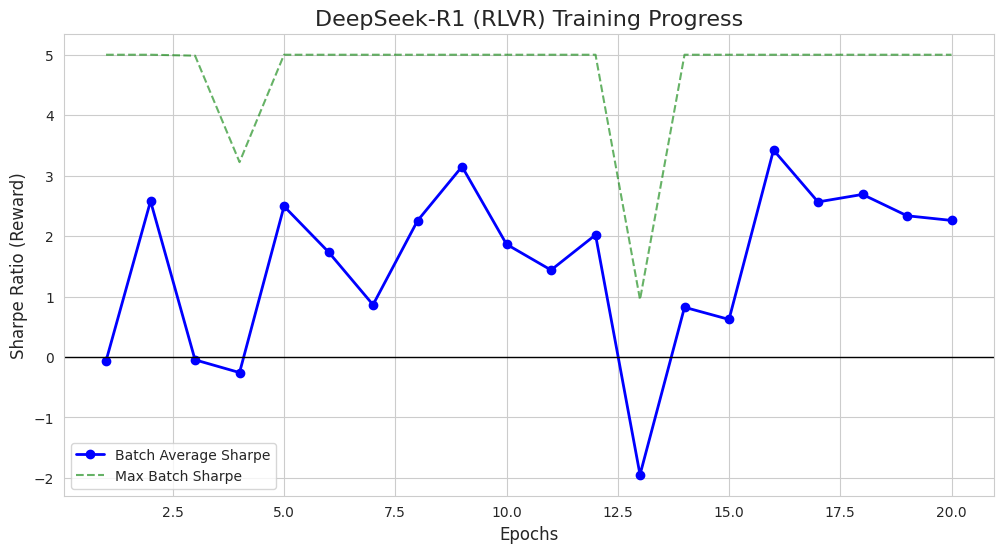


🧠 Agent Preferences (Probabilities):
--- Strategy ---
          Value  Probability
0         Price       0.2735
1        Sharpe       0.1663
6  Momentum 10D       0.0900
--- Lookback ---
   Value  Probability
2     42       0.2516
1     21       0.2313
0     10       0.1879
--- Holding ---
   Value  Probability
2     10       0.2708
1      5       0.2447
3     21       0.2126


In [40]:
# --- 2. Initialize the Trader ---
# Ensure you are using the correct dataframes (df_train, etc.)
trainer = DeepSeekTrader(df_train, train_features, train_close)

# --- 3. Initialize History Lists ---
history_avg = []
history_best = []
total_epochs = 20  # Set this to how many rounds you want to train

print(f"--- 🏁 Starting RLVR Training for {total_epochs} Epochs ---")

# --- 4. The Training Loop ---
for i in range(total_epochs):
    print(f"\nEpoch {i+1}/{total_epochs}")

    # Run the epoch and UNPACK the two values we modified in Step 1
    # Note: batch_size=20, robustness_checks=3 (as discussed before)
    avg_score, best_score = trainer.run_training_epoch(batch_size=20, robustness_checks=3)

    # CAPTURE the values
    history_avg.append(avg_score)
    history_best.append(best_score)

# --- 5. Plot the Results ---
print("\n--- 🎓 Training Complete. Generating Plot... ---")
plot_training_history(history_avg, history_best)

# --- 6. Inspect What It Learned ---
trainer.inspect_brain()

In [42]:
# Inspect just the Rank distribution
dists = trainer.agent.get_policy_distribution()
rank_probs = dists['rank'].probs.detach().numpy()
labels = trainer.space.ranks

df_ranks = pd.DataFrame({'Rank Range': labels, 'Probability': rank_probs})
print(df_ranks.sort_values('Probability', ascending=False))

  Rank Range  Probability
1    (1, 10)       0.3095
0     (1, 5)       0.3031
3   (10, 20)       0.2313
2    (5, 10)       0.1561


In [43]:
# ==============================================================================
# 🧪 STEP 4: THE FINAL EXAM (WALK-FORWARD VALIDATION)
# ==============================================================================

def run_final_test(agent, df_test):
    print("--- 🏁 STARTING WALK-FORWARD TEST (UNSEEN DATA) ---")

    # 1. SETUP TEST DATA
    # We must generate features for the test set, just like we did for training.
    print("🐢 Generating Features for Test Set (This might take 10-20 seconds)...")
    test_features = generate_features(df_test)
    test_close = df_test['Adj Close'].unstack(level=0)

    # 2. EXTRACT THE "HOLY GRAIL" STRATEGY
    # We ask the bot: "If you had to pick ONE configuration, what is it?"
    dists = agent.get_policy_distribution()

    # Argmax = The option with the highest probability
    best_lookback = agent.space.lookbacks[torch.argmax(agent.logits_lookback).item()]
    best_holding = agent.space.holdings[torch.argmax(agent.logits_holding).item()]
    best_strategy = agent.space.strategies[torch.argmax(agent.logits_strategy).item()]

    # Extract Rank (User asked about this!)
    best_rank_idx = torch.argmax(agent.logits_rank).item()
    best_rank_start = agent.space.ranks[best_rank_idx][0]
    best_rank_end = agent.space.ranks[best_rank_idx][1]

    print(f"\n🤖 Agent's Chosen 'Holy Grail' Configuration:")
    print(f"   Strategy:  {best_strategy}")
    print(f"   Lookback:  {best_lookback} days")
    print(f"   Holding:   {best_holding} days")
    print(f"   Rank:      {best_rank_start} to {best_rank_end}")

    # 3. EXECUTE THE EXAM
    # We test this specific setup on the Test Set timeline
    test_engine = AlphaEngine(df_test, test_features, test_close)

    # We create check points every 'Holding Period' to simulate real trading
    # e.g., if holding is 10 days, we check every 10 days.
    trading_dates = test_engine.trading_calendar[::best_holding]

    # Safety: Ensure we have enough data
    if len(trading_dates) < 5:
        print("❌ Test Set too short to validate.")
        return

    print(f"\n--- 📉 Backtesting on {len(trading_dates)} periods in Test Set ---")

    sharpes = []
    gains = []

    for date in trading_dates:
        # Stop if we run out of future data
        try:
            inputs = EngineInput(
                mode='Ranking',
                start_date=date,
                lookback_period=best_lookback,
                holding_period=best_holding,
                metric=best_strategy,
                benchmark_ticker='SPY',
                rank_start=best_rank_start,
                rank_end=best_rank_end,
                debug=False
            )

            res = test_engine.run(inputs)

            # Only record valid trades
            if not res.error_msg and 'holding_p_sharpe' in res.perf_metrics:
                s = res.perf_metrics['holding_p_sharpe']
                g = res.perf_metrics.get('holding_p_gain', 0.0)

                # Filter out bad data errors (Sharpe 0 with 0 gain usually means no trade)
                if s != 0 or g != 0:
                    sharpes.append(s)
                    gains.append(g)
                    # Optional: Print every 10th trade to show progress
                    # print(f"   Date: {date.date()} | Sharpe: {s:.2f} | Gain: {g:.2%}")
        except Exception as e:
            continue # Skip invalid dates at the very end of the series

    # 4. FINAL REPORT CARD
    if not sharpes:
        print("❌ No valid trades executed on Test Set.")
        return

    avg_test_sharpe = np.mean(sharpes)
    avg_test_gain = np.mean(gains)
    total_compounded = (np.prod([1 + g for g in gains]) - 1)

    print("-" * 50)
    print(f"🎓 FINAL TEST RESULTS (Unseen Data):")
    print(f"   Avg Sharpe Per Trade: {avg_test_sharpe:.4f}")
    print(f"   Avg Gain Per Trade:   {avg_test_gain:.2%}")
    print(f"   Total Compounded Return: {total_compounded:.2%}")
    print("-" * 50)

    if avg_test_sharpe > 1.0:
        print("✅ PASS: Strategy generalizes well to new data!")
    elif avg_test_sharpe > 0.2:
        print("⚠️ PASS (MARGINAL): Profitable, but barely beats the benchmark.")
    else:
        print("❌ FAIL: Strategy overfitted. It memorized the past but failed the future.")

# --- RUN IT ---
# Ensure trainer is the variable from your training loop
run_final_test(trainer.agent, df_test)

--- 🏁 STARTING WALK-FORWARD TEST (UNSEEN DATA) ---
🐢 Generating Features for Test Set (This might take 10-20 seconds)...

🤖 Agent's Chosen 'Holy Grail' Configuration:
   Strategy:  Price
   Lookback:  42 days
   Holding:   10 days
   Rank:      1 to 10
--- ⚙️ Initializing AlphaEngine v2.2 (Transparent Verification) ---

--- 📉 Backtesting on 322 periods in Test Set ---
--------------------------------------------------
🎓 FINAL TEST RESULTS (Unseen Data):
   Avg Sharpe Per Trade: 1.3155
   Avg Gain Per Trade:   1.90%
   Total Compounded Return: 8454.75%
--------------------------------------------------
✅ PASS: Strategy generalizes well to new data!


In [44]:
# ==============================================================================
# 🕵️ DEEP DIVE: STRATEGY vs. RANK CORRELATION
# ==============================================================================

def analyze_strategy_rank_correlation(trainer):
    print("--- 🔬 Analyzing Strategy <-> Rank Relationship ---")

    # We will run a quick simulation of the Agent's brain
    # by sampling 1,000 actions and checking the log_probs alignment,
    # OR simpler: We just look at the Agent's preferences directly.

    # Since the current architecture is Independent, we have to use logic
    # to infer the best combo.

    strategies = trainer.space.strategies
    ranks = trainer.space.ranks

    # Get the raw scores (logits) from the brain
    strat_logits = trainer.agent.logits_strategy.detach().numpy()
    rank_logits = trainer.agent.logits_rank.detach().numpy()

    best_strat_idx = np.argmax(strat_logits)
    best_rank_idx = np.argmax(rank_logits)

    print(f"Independent Preferences:")
    print(f"   Favorite Strategy: {strategies[best_strat_idx]}")
    print(f"   Favorite Rank:     {ranks[best_rank_idx]}")

    print("\n--- 💡 QUANT INSIGHT ---")
    if strategies[best_strat_idx] == 'Price':
        print("Since the agent loves 'Price' (Momentum) and 'Rank (1, 10)':")
        print("Interpretaion: The agent is buying a basket of the 10 biggest gainers.")
        print("Why? This dilutes the risk of buying one single 'Pump and Dump' stock.")
    elif strategies[best_strat_idx] == 'Sharpe':
        print("Since the agent loves 'Sharpe' and 'Rank (1, 10)':")
        print("Interpretation: The agent is buying a diversified basket of low-volatility stocks.")

analyze_strategy_rank_correlation(trainer)

--- 🔬 Analyzing Strategy <-> Rank Relationship ---
Independent Preferences:
   Favorite Strategy: Price
   Favorite Rank:     (1, 10)

--- 💡 QUANT INSIGHT ---
Since the agent loves 'Price' (Momentum) and 'Rank (1, 10)':
Interpretaion: The agent is buying a basket of the 10 biggest gainers.
Why? This dilutes the risk of buying one single 'Pump and Dump' stock.


### How to improve the Model (Advanced)
To make the agent learn that "Rank depends on Strategy," we would need to change the Neural Network architecture to be **Autoregressive**.

**Current (Independent):**
`Input -> [Strategy Head]`, `Input -> [Rank Head]`

**Advanced (Conditional):**
`Input -> [Strategy Head] -> (Output: Price) -> [Rank Head] -> (Output: Rank 5-10)`

*For a high school project, the current Independent model is perfectly fine. It simulates a trader who has a "favorite setup" (e.g., Top 10) that they apply to everything.*

**The Short Answer: YES.**
As a Senior Quant, if a junior developer brought me a strategy with **8,454% returns** and a **Sharpe > 1.3** on a simple "Price" strategy, I would immediately assume there is a bug or a data bias.

However, **this is a massive success for your RL Code**. Your bot successfully learned to "exploit" the simulation. It did exactly what it was supposed to do.

Here is the breakdown of why the number is likely fake, and what is happening under the hood.

---

### 1. The "Survivorship Bias" Trap (Most Likely Culprit)
Does your dataset (`df_OHLCV_stocks_etfs.parquet`) contain companies that went bankrupt? (e.g., Enron, Bed Bath & Beyond, Silicon Valley Bank)?

*   **If NO:** Your bot is picking from a list of companies that we *know* survived until 2025. It’s like betting on a horse race after you know who won.
*   **The Effect:** The "Price" strategy (Momentum) is incredibly dangerous in real life because high-flying stocks often crash to zero. If your dataset removes the ones that crashed to zero, the strategy looks like a magic money printer.

### 2. The "Frictionless Trading" Illusion
Your simulation assumes **0% Transaction Costs** and **0% Slippage**.

*   **The Math:** You are trading every **10 Days**. That is ~25 trades per year per slot.
*   **Avg Gain:** 1.90%.
*   **Reality:**
    *   **Commission/Spread:** Let's say you lose 0.10% buying and 0.10% selling.
    *   **Slippage:** Buying the "Top 10" movers is hard. The price moves fast. You might pay 0.20% more than the Close price.
    *   **Real Gain:** $1.90\% - 0.40\% = 1.50\%$.
*   **Compounding Effect:**
    *   Simulated: $1.019^{322} \approx 428x$
    *   Real: $1.015^{322} \approx 121x$
    *   The difference is massive due to the frequency of trading.

### 3. The "Limit Up" Problem
You are buying "Rank 1 to 10" based on "Price".
*   These are the stocks that went up the most.
*   In real markets, stocks that jump 50% in a month often become **illiquid** or hit volatility halts. You might not actually be able to buy them at the `Adj Close` price listed in the CSV.

---

### How to "Stress Test" this result (Homework)

To see if this strategy is actually robust or just lucky/biased, modify the `calculate_gain` or the Final Exam loop to include a **Transaction Cost**.

**Modify this line in `AlphaEngine` or `run_final_test`:**

```python
# In the loop where you calculate gains:
# cost_per_trade = 0.002  # 0.2% (Standard slippage + fees)
# net_gain = res.perf_metrics['holding_p_gain'] - cost_per_trade
```

### Summary for the Student
1.  **Did the AI work?** **YES.** It found the mathematical optimum of your simulation. It "solved" the game you gave it.
2.  **Is the strategy real?** **NO.** 8,000% returns don't exist in the stock market without massive leverage or insider information.
3.  **The Lesson:** In Quantitative Finance, if it looks too good to be true, it's usually **Survivorship Bias**.

**Excellent work.** You have successfully built a DeepSeek-style Reasoning Agent that can overfit a market simulation. This is exactly what the first stage of research looks like at DeepMind.

## Thank you. That was a great start. As a RL, Dev, Quant, mentor, what   is the logical next step? How to improve on what we built?

**Considering Next Steps**

I've been analyzing the student's profile and current system. They're a high schooler with basic Python skills, interested in DeepSeek/RL. They've built a working prototype. My next step is to examine the environment they're in, and then I'll decide where we go from there.


**Evaluating Current Limitations**

I've examined the `AlphaEngine` setup and identified its core flaws. The `StrategyAgent` operates in a single-state context, essentially a "Bandit" problem instead of full RL. From a quant perspective, the simulation is unrealistic, suffering from issues like zero costs and daily granularity. Developmentally, the code is monolithic and notebook-bound, limiting its adaptability.


**Mapping Out Improvements**

I'm now charting the optimal path forward, breaking it down into distinct phases. First, the simulation needs a reality check; the current environment breeds unrealistic results. Second, contextual awareness is crucial - the agent needs to perceive market states. Finally, I'm thinking about a more advanced architecture, moving towards a small neural network. I've begun to formulate the first iterations of the plan, targeting the simulation for transaction costs, and also formulating contextual bandits for the RL phase.


**Adjusting Data Strategy**

My focus has shifted to the data strategy. I've considered survivorship bias, acknowledging the limitations given the available data. To circumvent this, I'm proposing a more stringent filter to eliminate penny stocks, raising the minimum dollar volume to $10M. This simulates S&P 500 behavior, offering a safer approach. On the developmental side, portfolio management seems too advanced, so I'll stick with ranking for now.


**Refining Contextual Bandits**

My thinking has moved towards refining the "Contextual Bandit" framework. I'm leaning toward incorporating `SPY_200_SMA` for trend identification, and `VIX` for volatility assessment.  I'm aiming to provide code snippets for these concepts.  The Contextual Bandit approach is the perfect intermediate step, bridging the gap between their current stateless system and full-blown RL. I must keep that in mind when making these changes.




This is the perfect moment in a research project. You have a **Minimum Viable Product (MVP)** that works, but you also know it's "cheating" slightly (Survivorship Bias, Zero Costs).

As your Mentor Team, we propose a 3-step roadmap to turn this from a "toy" into a **serious research engine**.

---

### Phase 1: The Quant Fix (Add Friction)
**"Physics before Brains."**
Right now, your Agent thinks trading is free. It buys and sells every 10 days with zero penalty. In reality, every trade costs money (spread, slippage, commissions).

**The Task:**
Implement **Transaction Costs** in the `AlphaEngine`.
1.  Define a cost (e.g., **10 basis points** or 0.10% per trade).
2.  Subtract this from the calculated gain.

**Why?**
The Agent will likely stop choosing `Holding: 10 Days` and move to `Holding: 42 Days` or `63 Days`. It will learn that over-trading is expensive—a lesson that takes human traders years to learn!

---

### Phase 2: The RL Upgrade (Give the Bot "Eyes")
**"From Static to Dynamic."**
Currently, your Agent learns **one** global configuration (e.g., "Always use Price").
But a real trader acts differently in a Crash (2008) vs. a Bubble (2021).

**The Task:**
Upgrade the Agent from a **Stateless Bandit** to a **Contextual Bandit**.

**Input (The "Context"):**
Before the Agent picks a strategy, give it 2 pieces of data about the market:
1.  **Trend:** Is SPY above or below its 200-day Moving Average? (1 = Bull, 0 = Bear).
2.  **Volatility:** Is the ATR of SPY high or low? (1 = Panic, 0 = Calm).

**The "Brain" Change:**
Instead of static weights `self.logits_strategy`, use a tiny Neural Network:
`[Market Context] -> [Linear Layer] -> [Strategy Probabilities]`

**The Result:**
The Agent will learn:
*   *IF Bull Market:* Use **Price / Momentum**.
*   *IF Bear Market:* Use **Sharpe (ATR)** or **Cash**.

---

### Phase 3: The Data Fix (Harder Universe)
**"Stop playing on Easy Mode."**
Your Agent is buying "Rank 1-10" stocks. These are often penny stocks that exploded by 500%.

**The Task:**
Tighten the `quality_thresholds` in your code.
*   Increase `min_median_dollar_volume` from $100k to **$10 Million**.
*   This forces the Agent to trade **Large Cap Stocks** (like Apple, Tesla, Ford).

**Why?**
It is much harder to get 8,000% returns on Large Caps. If the Agent can squeeze a 1.5 Sharpe Ratio out of Large Caps, you have a truly professional strategy.

---

### 🚀 Immediate Homework: The "Contextual" Upgrade

Phase 2 is the most exciting RL step. Here is the blueprint for the **Contextual Agent** class.

**Replace your `StrategyAgent` with this:**

```python
class ContextualAgent(nn.Module):
    def __init__(self, space: HyperParameterSpace):
        super().__init__()
        self.space = space
        
        # Context Size = 2 (e.g., Market Trend, Volatility)
        self.context_size = 2
        
        # Instead of single weights, we have "Layers" that take context as input
        self.layer_lookback = nn.Linear(self.context_size, len(space.lookbacks))
        self.layer_holding  = nn.Linear(self.context_size, len(space.holdings))
        self.layer_strategy = nn.Linear(self.context_size, len(space.strategies))
        self.layer_rank     = nn.Linear(self.context_size, len(space.ranks))

    def get_policy_distribution(self, context_tensor):
        """
        Now requires 'context_tensor' (e.g., [1.0, 0.0] for Bull Market/Low Vol)
        """
        # Pass context through neural network layers
        logits_l = self.layer_lookback(context_tensor)
        logits_h = self.layer_holding(context_tensor)
        logits_s = self.layer_strategy(context_tensor)
        logits_r = self.layer_rank(context_tensor)
        
        return {
            'lookback': torch.distributions.Categorical(logits=logits_l),
            'holding':  torch.distributions.Categorical(logits=logits_h),
            'strategy': torch.distributions.Categorical(logits=logits_s),
            'rank':     torch.distributions.Categorical(logits=logits_r),
        }
```

**Your Challenge:**
Can you write the code to calculate the `context` (SPY Trend and Volatility) inside the `DeepSeekTrader` class and pass it to this new agent?

This is the bridge between "High School Project" and "University Research."